# **The Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology. We consider a flow across a rectangular channel with a circular hole, and we analyze the influence of this hole on the fluid speed and pressure. This report shed some light on the popular Taylor-Hood mixed element, which makes the solution stable. We also show alternative to remain numerically stable.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [1]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
    
from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

--2023-04-02 13:22:04--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-04-02 13:22:05 (40.4 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/f865b92/releases/pybind11-install.s

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0$

together with suitable boundary conditions.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

To derive the weak form of the equations, multiply the momentum equation by $v\in V$ and the continuity equation by $q\in Q$, and then integrate over the domain $\Omega$ and use Green's formula
$
(\nabla p -\Delta u,v) = -(p,\nabla \cdot v) + (\nabla u, \nabla v) 
+ <pn - \nabla u\cdot n, v>_{\Gamma}
$

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) 
+ <pn - \nabla u\cdot n, v>_{\partial \Omega} = (f,v)$

for all test functions $(v,q) \in V\times Q$. 

$
(v,w) = \int_{\Omega} v\cdot w ~dx, \quad 
<v,w>_{\partial \Omega} = \int_{\partial \Omega} v\cdot w~ds
$

We divide the boundary into $\partial \Omega=\Gamma_D \cup \Gamma_N$, with the different boundary conditions

$
u = g_D,\quad x\in \Gamma_D,
$

$
-\nu \nabla u\cdot n + pn = g_N, \quad x\in \Gamma_N,
$

For $x\in \Gamma_D$ the test function $v=0$. Hence, with $g_N=0$ the boundary term is zero. 

The equations can be expressed in residual form

$r(u,p;v,q) = - (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) - (f,v)$

We use inf-sup stable Taylor-Hood approximation spaces, 
and to implement the velocity boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, with $C>0$ a constant and $h$ the local mesh size. At outflow we use a "do nothing" stress free boundary condition. 

In this report, we analyze what happens if we change the inf-sup stable Taylor-Hood approximation spaces, by setting linear or quadratic interpolations for both velocity and pressure. We will also show what happens on the pressure if we invert the flow in the opposite direction. Finally, we also focus on alternatives to stabilize the numerical solution if we do not use Taylor-Hood approximation spaces, as Brezzi-Pitkäranta stabilization, that modifies the residual equation as follows : 

$r(u,p;v,q)=−(p,∇⋅v)+(∇u,∇v)+(∇⋅u,q)−(f,v)+C^\prime h^2 (∇p,∇q)$

with a constant $C^\prime>0$. We here omit the boundary terms in the residual solution that are obviously taken into account in the code.

# **Method**
In this section, we define the domain of the flow, the FEM elements and boundary conditions. We will define 5 problems. The first three will be from left to right flows with three different settings of interpolation orders in velocity and pressure : second order in velocity and first in pressure, first order for both, and second order for both. In the problem 4, we analyze the first above setting (Taylor-Hood approximation spaces) with a reverse flow from right to left. Finally in problem 5, we take both first order order interplations for velocity and pressure with a Brezzi-Pitkäranta stabilization, which was introduced in the introduction section.

**Define domain and mesh** \\
We consider here a rectangular channel of length L=4 and high H=2, with a hole of radius 0.2 in its center. We define the resolution of the mesh to a uniform mesh size of h=1/32. We then locally refine the mesh once in a circle of radius 1 centered at the circular hole. We apply this for all 5 problems.

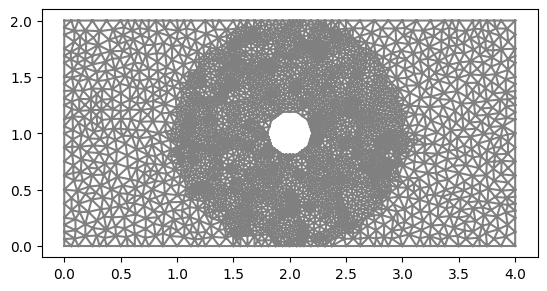

In [3]:
# Define rectangular domain 
L = 4
H = 2

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5*L,0.5*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5*L, 0.5*H)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**\
We define here the mixed finite element spaces for velocity and pressure. We use here by default quadratic interpolation for velocity and linear interpolation for pressure, namely Taylor-Hood mixed elements. We also apply both linear interpolations in problem 2 and 3; we also apply both quadratic interpolations for problem 3. This is for experimenting.

In [4]:
# Generate mixed finite element spaces (for velocity and pressure)
# Default set
VE1 = VectorElement("CG", mesh.ufl_cell(), 2)
QE1 = FiniteElement("CG", mesh.ufl_cell(), 1) 
VE2 = VectorElement("CG", mesh.ufl_cell(), 1) 
QE2 = FiniteElement("CG", mesh.ufl_cell(), 1) 
VE3 = VectorElement("CG", mesh.ufl_cell(), 2) 
QE3 = FiniteElement("CG", mesh.ufl_cell(), 2)
VE4 = VectorElement("CG", mesh.ufl_cell(), 2) 
QE4 = FiniteElement("CG", mesh.ufl_cell(), 1)
VE5 = VectorElement("CG", mesh.ufl_cell(), 1) 
QE5 = FiniteElement("CG", mesh.ufl_cell(), 1)

def set_elements(VE, QE):
  WE = VE * QE
  W = FunctionSpace(mesh, WE)
  V = FunctionSpace(mesh, VE)
  Q = FunctionSpace(mesh, QE)
  w = Function(W)
  (u, p) = (as_vector((w[0],w[1])), w[2])
  (v, q) = TestFunctions(W)
  return WE,W,V,Q,w,u,p,v,q

# Create elements for each of the 5 problems
WE1,W1,V1,Q1,w1,u1,p1,v1,q1 = set_elements(VE1,QE1)
WE2,W2,V2,Q2,w2,u2,p2,v2,q2 = set_elements(VE2,QE2)
WE3,W3,V3,Q3,w3,u3,p3,v3,q3 = set_elements(VE3,QE3)
WE4,W4,V4,Q4,w4,u4,p4,v4,q4 = set_elements(VE4,QE4)
WE5,W5,V5,Q5,w5,u5,p5,v5,q5 = set_elements(VE5,QE5)


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_8dcc7ff1a2a5155b4ca8e0d58559cea9e604269b

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00405669 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.495326 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_6ab56968c6ffa883272fd990bd40fad8bf858cca

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00338578 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0182607 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_f4c31f6e8b0e7ddceb14ce599aa08d063c1bdf82

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.005265 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0245984 seconds.

INFO:FFC:Compiler stage 3:

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00604391 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0227232 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_7be33e76391bc442bcaa4c2b2a46023ee3c664e0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00801301 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.059

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00308824 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0205519 seconds.

INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_2fc4f57ef69f0c0b716c41391fb1c35ec6ba096e

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00626397 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.025

**Define boundary conditions**\
Here we define the inflow, outflow and wall boundaries in a simple way, namely $ib$, $ob$ and $wb$. Note that we also define the velocity profile by $u_{in}$. All problems except problem 4 have flow from left to right, so they have the same definitions, just the for problem 4 we switch the inflow boundary with the outflow one and we change velocity sign.

In [5]:
# Examples of inflow and outflow conditions
XMIN = 0.0; XMAX = L
YMIN = 0.0; YMAX = H

uin1   = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V1.ufl_element())  # if flow from left to right 
uin2   = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V2.ufl_element())  # if flow from left to right 
uin3   = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V3.ufl_element())  # if flow from left to right 
uin4   = Expression(("-4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V4.ufl_element()) # !!! if flow from right to left
uin5   = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V5.ufl_element())  # if flow from left to right
#pout = 0.0

# Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib1   = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q1.ufl_element()) # if flow from left to right 
ib2   = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q2.ufl_element()) # if flow from left to right 
ib3   = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q3.ufl_element()) # if flow from left to right 
ib4   = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q4.ufl_element())  # !!! if flow from right to left 
ib5   = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q5.ufl_element()) # if flow from left to right 

ob1   = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q1.ufl_element()) # if flow from left to right 
ob2   = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q2.ufl_element()) # if flow from left to right 
ob3   = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q3.ufl_element()) # if flow from left to right
ob4   = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q4.ufl_element()) # !!! if flow from right to left
ob5   = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q5.ufl_element()) # if flow from left to right

wb1 = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q1.ufl_element())
wb2 = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q2.ufl_element())
wb3 = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q3.ufl_element())
wb4 = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q4.ufl_element())
wb5 = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q5.ufl_element())


# **Results**


**Define and solve variational problem**\
We define and solve variational problem below, for all 5 problems, by explicitly writing the residual form that leads to a linear system to solve. The residual form is the same as explained in the introduction part, where we added explicitly the boundary terms. For the problem 5, we also add the Brezzi-Pitkäranta stabilization term in the residual form, with a constant $c=1$ chosen arbitrary and proved to work for this case.

In [6]:
h = CellDiameter(mesh)
C = 1.0e3
c = 1
gamma = C/h

# Define 5 problems and their residual
f1 = Expression(("0.0","0.0"), element = V1.ufl_element())
f2 = Expression(("0.0","0.0"), element = V2.ufl_element())
f3 = Expression(("0.0","0.0"), element = V3.ufl_element())
f4 = Expression(("0.0","0.0"), element = V4.ufl_element())
f5 = Expression(("0.0","0.0"), element = V5.ufl_element())

residual1 = ( - p1*div(v1)*dx + inner(grad(u1), grad(v1))*dx + div(u1)*q1*dx + 
            gamma*(ib1*inner(u1 - uin1, v1) + wb1*inner(u1, v1))*ds - inner(f1, v1)*dx )
residual2 = ( - p2*div(v2)*dx + inner(grad(u2), grad(v2))*dx + div(u2)*q2*dx + 
            gamma*(ib2*inner(u2 - uin2, v2) + wb2*inner(u2, v2))*ds - inner(f2, v2)*dx )
residual3 = ( - p3*div(v3)*dx + inner(grad(u3), grad(v3))*dx + div(u3)*q3*dx + 
            gamma*(ib3*inner(u3 - uin3, v3) + wb3*inner(u3, v3))*ds - inner(f3, v3)*dx )
residual4 = ( - p4*div(v4)*dx + inner(grad(u4), grad(v4))*dx + div(u4)*q4*dx + 
            gamma*(ib4*inner(u4 - uin4, v4) + wb4*inner(u4, v4))*ds - inner(f4, v4)*dx )
residual5 = ( - p5*div(v5)*dx + inner(grad(u5), grad(v5))*dx + div(u5)*q5*dx + 
            gamma*(ib5*inner(u5 - uin5, v5) + wb5*inner(u5, v5))*ds - inner(f5, v5)*dx + c * h**2 * inner(grad(p5),grad(q5))*dx) #!!! Add the stabilisation term

# Solve algebraic system 
solve(residual1 == 0, w1) 
solve(residual2 == 0, w2)
solve(residual3 == 0, w3)
solve(residual4 == 0, w4)
solve(residual5 == 0, w5)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9fede427ebf5530d011c2f194e877e2185763f87

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              5
  Coefficients:                        '[f_30, f_69, f_74, f_84, f_89]'
  Unique elements:                     'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                                       r<2 x CG2(?,?)>, CG1(?,?), Vector<2 x CG1(?,?
                                       )>'
  Unique sub elements:                 'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                                       r<2 x

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00617456 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0189362 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_710e042cbbb571d8e4a15105e3df3c9c1062d254

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                2
  Arguments:                           '(v_0, v_1)'
  Number of coefficients:              2
  Coefficients:                        '[f_74, f_84]'
  Unique elements:                     'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, CG1(?
                                       ,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:                 'Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, CG1(?
                                       ,?), Vector<2 x CG1(?,?)>, Vector<2 x CG2(?,?
                                  

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_5f332785f9aa1735826d65b5319a7b001aebd798

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              5
  Coefficients:                        '[f_39, f_70, f_75, f_85, f_90]'
  Unique elements:                     'Mixed<Vector<2 x CG1(?,?)>, CG1(?,?)>, Vecto
                                       r<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:                 'Mixed<Vector<2 x CG1(?,?)>, CG1(?,?)>, Vecto
                                       r<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6a804fc87b664cb1d0f1a0569ccfbe8c90e9176f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                2
  Arguments:                           '(v_0, v_1)'
  Number of coefficients:              2
  Coefficients:                        '[f_75, f_85]'
  Unique elements:                     'Mixed<Vector<2 x CG1(?,?)>, CG1(?,?)>, CG1(?
                                       ,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:                 'Mixed<Vector<2 x CG1(?,?)>, CG1(?,?)>, CG1(?
                                       ,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d91304500244793cc207eaa682878d3131898c52

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              5
  Coefficients:                        '[f_48, f_71, f_76, f_86, f_91]'
  Unique elements:                     'Mixed<Vector<2 x CG2(?,?)>, CG2(?,?)>, Vecto
                                       r<2 x CG2(?,?)>, CG2(?,?), Vector<2 x CG1(?,?
                                       )>'
  Unique sub elements:                 'Mixed<Vector<2 x CG2(?,?)>, CG2(?,?)>, Vecto
                                       r<2 x

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_585f71280a55cdd492de9a9be8cd2cb47f0705bf

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                2
  Arguments:                           '(v_0, v_1)'
  Number of coefficients:              2
  Coefficients:                        '[f_76, f_86]'
  Unique elements:                     'Mixed<Vector<2 x CG2(?,?)>, CG2(?,?)>, CG2(?
                                       ,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:                 'Mixed<Vector<2 x CG2(?,?)>, CG2(?,?)>, CG2(?
                                       ,?), Vector<2 x CG1(?,?)>, Vector<2 x CG2(?,?
                                  

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_744a1ff7389b4d21796ac96a9e24d7553c9167a9

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              5
  Coefficients:                        '[f_66, f_73, f_78, f_88, f_93]'
  Unique elements:                     'Mixed<Vector<2 x CG1(?,?)>, CG1(?,?)>, Vecto
                                       r<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:                 'Mixed<Vector<2 x CG1(?,?)>, CG1(?,?)>, Vecto
                                       r<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c2a36f30fa9cad902de5a251934446b7e1ababad

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                2
  Arguments:                           '(v_0, v_1)'
  Number of coefficients:              2
  Coefficients:                        '[f_78, f_88]'
  Unique elements:                     'Mixed<Vector<2 x CG1(?,?)>, CG1(?,?)>, CG1(?
                                       ,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:                 'Mixed<Vector<2 x CG1(?,?)>, CG1(?,?)>, CG1(?
                                       ,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO

**Visualize solution and export files**\
In the above method section, we designed 5 flow problems accross a channel with a circular hole in its center. The three first experiment the influence of interpolation order for velocity and pressure. The problem 4 experiment the impact of changning flow direction. Finally problem 5 experiments the importance of adding stabilization terms in certain cases. All the results are displayed below by experiment.

First of all, what is we play on the interpolation order of velocity and pressure. If we take by default quadratic and linear respectively for both, namely the Taylor-Hood mixed element space, we get a nice solution, stable, illustrated as problem 1 below. We can cleary see below the velocity direction going around the hole and the velocity magnitude increase above and below, as there is a compression of the fluid due to the hole, which must then be compensated by fluid acceleration. We also clearly see the pressure distribution, higher before and lower after the hole, which is intuitive. We see the pressure levels distinctly on the figure. Therefore the solution is stable and makes physical sense.\
If we change to a linear (problem 2) or quadratic (problem 3) interpolation for both the velocity and pressure, we get an unstable solution. Indeed, we clearly see spurious oscillations on the pressure plot, especially around the hole. The pressure curve levels disappeared, which makes the solution not physically relevant anymore. The velocity here seems to stay consistent however, which might not be the case if we investigate for more extreme scenarios. We can conclude that Taylor-Hood mixed element space is a stable choice, while taking same order for pressure and velocity is not a good idea.


rm: cannot remove 'results-NS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c6b4a02fee68f7686f0465e333e494b06b61787f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), 
                             CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0388246 seconds.

INFO:FFC:Compiler stage 2: Co

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3d05bc04ea75b80e5d525a8396e89d2f4a6304b6

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00409055 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0151322 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_a712bb565d87c5e1d5625ade0197191374301487

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00617576 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0158653 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_d123cefaaa5b67d0e0b75375e2b0e3f4ea1f443f

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00555968 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0157676 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_949fd8d0ce307bb0cc6395b639b6fb3c4f39bfdb

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00481439 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0165486 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_57e62bc067fd4e90a89fa19b659b6c786f0f36f6

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00534773 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0123286 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c9dbef7cf00a55c7da61d3f11cce356cbed02771

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_30]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Mixed<Vector<2 x CG2(?,?)>, CG1(
                             ?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Mixed<Vector<2 x CG2(?,?)>, CG1(
                             ?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_de

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_c9a169dd48fec4c87377f4d20ffcd2cd87f501ec

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00392127 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0204895 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4c58925ba7416ca95a1ece370e5d12c1ae3d39d2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0500221 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a97d4b782d2133a79f90f27b1406c8d68e32bdcd

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_30]'
  Unique elements:           'CG1(?,?), Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                             r<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Mixed<Vector<2 x CG2(?,?)>, CG1(?,?)>, Vecto
                             r<2 x CG1(?,?)>, Vector<2 x CG2(?,?)>, CG2(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d48b8d31192cba7fc017f8f5374cd24d1abc28f5

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0275774 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d1c10bb2d63d726b6b706a708ab053709c2df2c8

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_39]'
  Unique elements:           'Vector<2 x CG1(?,?)>, Mixed<Vector<2 x CG1(?,?)>, CG1(
                             ?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, Mixed<Vector<2 x CG1(?,?)>, CG1(
                             ?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_5f33d837017d36e1a2a1cf4723dbb7402ece84e8

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00440168 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.01443 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4a396fd1f4929994fdba929cae932a0c8df39834

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_39]'
  Unique elements:           'CG1(?,?), Mixed<Vector<2 x CG1(?,?)>, CG1(?,?)>, Vecto
                             r<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Mixed<Vector<2 x CG1(?,?)>, CG1(?,?)>, Vecto
                             r<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_3e5012530abfded9a4f12341b909b214b426022e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_48]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Mixed<Vector<2 x CG2(?,?)>, CG2(
                             ?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Mixed<Vector<2 x CG2(?,?)>, CG2(
                             ?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_de

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_b5c053b37d760547b63c4cd7e55efa1c6c4e3116

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00311804 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0166793 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_8cebec0133cfddbc860381b58cbb7d9e3676d4d5

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG2(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0514491 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_1171480c50cfd9ee3d2bb537b47dbd4d2d8e6725

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_48]'
  Unique elements:           'CG2(?,?), Mixed<Vector<2 x CG2(?,?)>, CG2(?,?)>, Vecto
                             r<2 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Mixed<Vector<2 x CG2(?,?)>, CG2(?,?)>, Vecto
                             r<2 x CG1(?,?)>, Vector<2 x CG2(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO

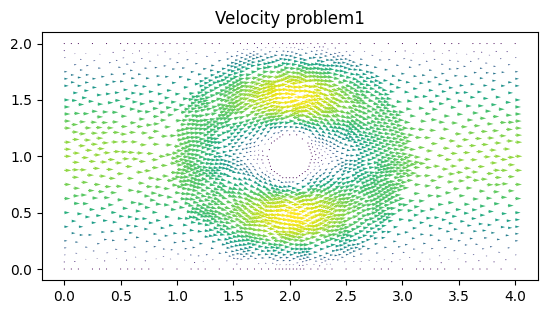

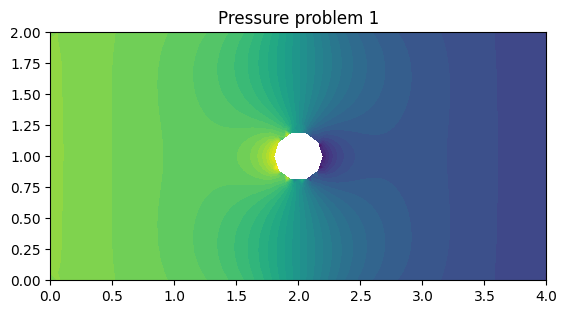

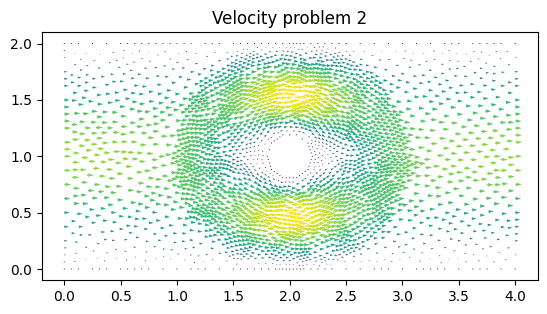

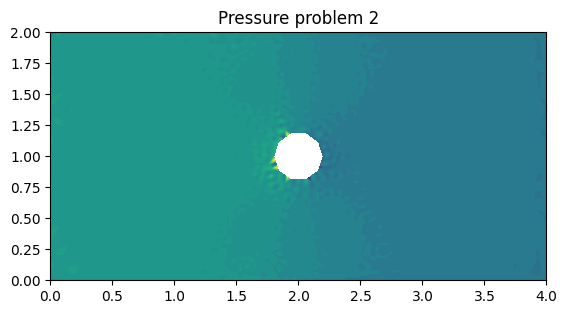

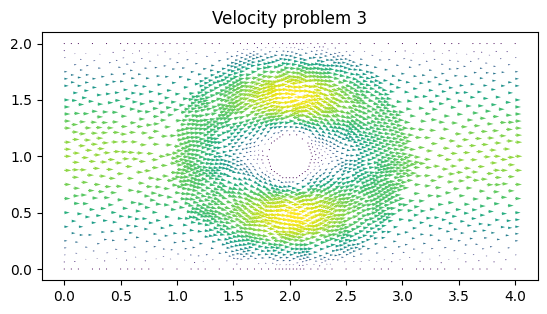

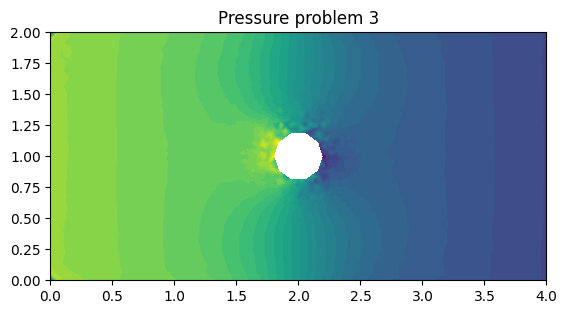

In [7]:
!rm results-NS/*

u_1 = project(u1, V1)
p_1 = project(p1, Q1)

u_2 = project(u2, V2)
p_2 = project(p2, Q2)

u_3 = project(u3, V3)
p_3 = project(p3, Q3)

# Plot solution
plt.figure()
plot(u_1, title="Velocity problem1")
plt.figure()
plot(p_1, title="Pressure problem 1")

plt.figure()
plot(u_2, title="Velocity problem 2")
plt.figure()
plot(p_2, title="Pressure problem 2")

plt.figure()
plot(u_3, title="Velocity problem 3")
plt.figure()
plot(p_3, title="Pressure problem 3")
                   
plt.show()



Secondly, if we change the flow direction from right to left, by keeping the initial settings, illustrated as problem 4, we clearly see that the pressure profile changes accordingly. Indeed, now the fluid encounters the hole from left to right, so the pressure is higher on the left and lower on the right. The velocity direction also changes accordingly.



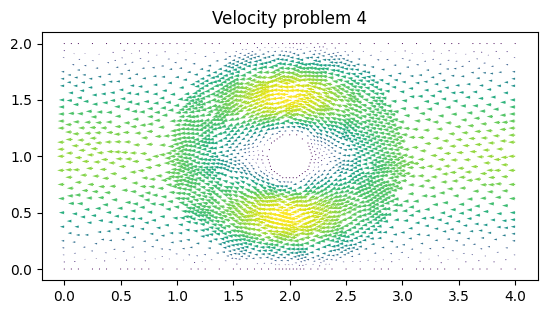

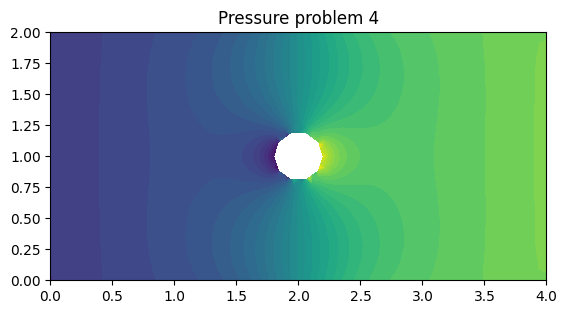

In [8]:
u_4 = project(u4, V4)
p_4 = project(p4, Q4)

plt.figure()
plot(u_4, title="Velocity problem 4")
plt.figure()
plot(p_4, title="Pressure problem 4")

plt.show()

Finally, if we want to stabilize the solution by still using linear or second order interpolation for pressure and velocity, we can use the Brezzi-Pitkäranta stabilization by decommenting the lines above where we define and solve variational problem. We chose an arbitrary constant that works for both cases. Indeed below we illustarte for the linear interpolation for both velocity and pressure, as problem 5, and you can see the solution is now stable again, despite the interpolation choice that was not, see problem 2. We get the same conclusion if we set both interpolations to second order.

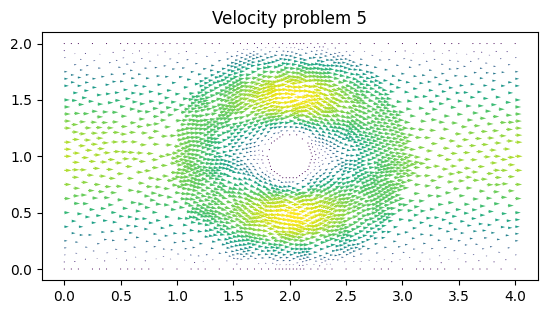

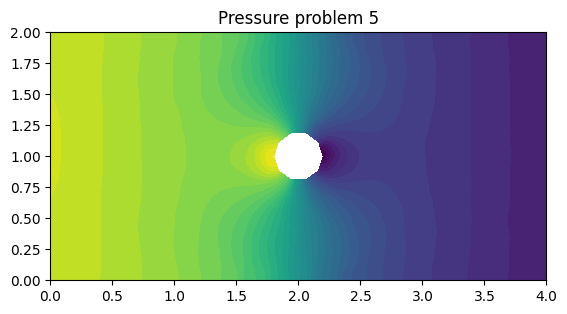

In [9]:
u_5 = project(u5, V5)
p_5 = project(p5, Q5)

plt.figure()
plot(u_5, title="Velocity problem 5")
plt.figure()
plot(p_5, title="Pressure problem 5")

plt.show()

# **Discussion**

We provided in this report three kind of experiments to realize in order to emphasize interesting results related to Stokes equations, and more generally to Navier-Stokes equations. First, we can indeed see according to theory that Taylor-Hood mixed finite element method is stable, whereas both linear or quadratic interpolations for velocity and pressure are not. This is because they do not respect the the inf-sup condition, that is necessary for stability. 
Secondly we illustrated the symmetry of the problem by changing the flow direction.
Finally, we implemented the Brezzi-Pitkäranta stabilization, which works as expected. It stabilizes methods that are not satisfying the inf-sup condition, by adding a stabilizing term in the residual equation form.
To conclude, all the theory of the course related to the lab is confirmed with the given results, using the FEniCS libraries to solve the Stokes equations in 2D. 